In [1]:
import scanpy as scp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy as sp
import pandas as pd
import bbknn
import igraph

from scCustomFunctions import *
from parameters import *

import warnings
warnings.filterwarnings('ignore')

In [4]:
a = loadData(QC_imputed=True,Normalized=True,Log1p=True)

# Computation of full dataset PCA for time integration (can be skipped)

In [5]:
X = np.zeros([a.obs.index.astype(int).max()+1,N_PCS])

#Global computation of HVGs and PCs
scp.pp.highly_variable_genes(a,flavor=HVG_METHOD)
remove_highly_variable_genes(a,SKIP_GENES) #Remove genes related with sex or cell cycle
scp.pp.pca(a,n_comps=N_PCS,use_highly_variable=USE_HVGs)

for j,stage in enumerate(a.obs["stage"].unique()[:]):
    
    b = a[a.obs["stage"]==stage,:].copy()
    b.obs["stage"]=b.obs["stage"].astype(str)
    b.obs["sample"]=b.obs["sample"].astype(str)
    
    scp.external.pp.harmony_integrate(b,"sample")
    
    index = b.obs.index.values.astype(int)
    
    #Load data from batch correction    
    X[index,:] = b.obsm["X_pca_harmony"]
    
a.obsm["X_pca_harmony"] = X[a.obs.index.values.astype(int),:]

2021-07-31 10:39:43,045 - harmonypy - INFO - Iteration 1 of 10
2021-07-31 10:39:43,399 - harmonypy - INFO - Iteration 2 of 10
2021-07-31 10:39:43,738 - harmonypy - INFO - Iteration 3 of 10
2021-07-31 10:39:43,898 - harmonypy - INFO - Iteration 4 of 10
2021-07-31 10:39:44,024 - harmonypy - INFO - Converged after 4 iterations
2021-07-31 10:39:44,849 - harmonypy - INFO - Iteration 1 of 10
2021-07-31 10:39:46,097 - harmonypy - INFO - Iteration 2 of 10
2021-07-31 10:39:47,340 - harmonypy - INFO - Iteration 3 of 10
2021-07-31 10:39:48,596 - harmonypy - INFO - Converged after 3 iterations
2021-07-31 10:39:48,709 - harmonypy - INFO - Iteration 1 of 10
2021-07-31 10:39:48,868 - harmonypy - INFO - Iteration 2 of 10
2021-07-31 10:39:49,024 - harmonypy - INFO - Iteration 3 of 10
2021-07-31 10:39:49,146 - harmonypy - INFO - Iteration 4 of 10
2021-07-31 10:39:49,203 - harmonypy - INFO - Converged after 4 iterations
2021-07-31 10:39:50,451 - harmonypy - INFO - Iteration 1 of 10
2021-07-31 10:39:52,18

In [7]:
np.save("dataRaw/X_pca_harmony_full.npy",a.obsm["X_pca_harmony"])
np.save("dataRaw/X_pca_full.npy",a.obsm["X_pca"])

In [9]:
a.obsm["X_pca_harmony"] = np.load("dataRaw/X_pca_harmony_full.npy")
a.obsm["X_pca"] = np.load("dataRaw/X_pca_full.npy")

# Paga by stages and samples

... storing 'sample' as categorical


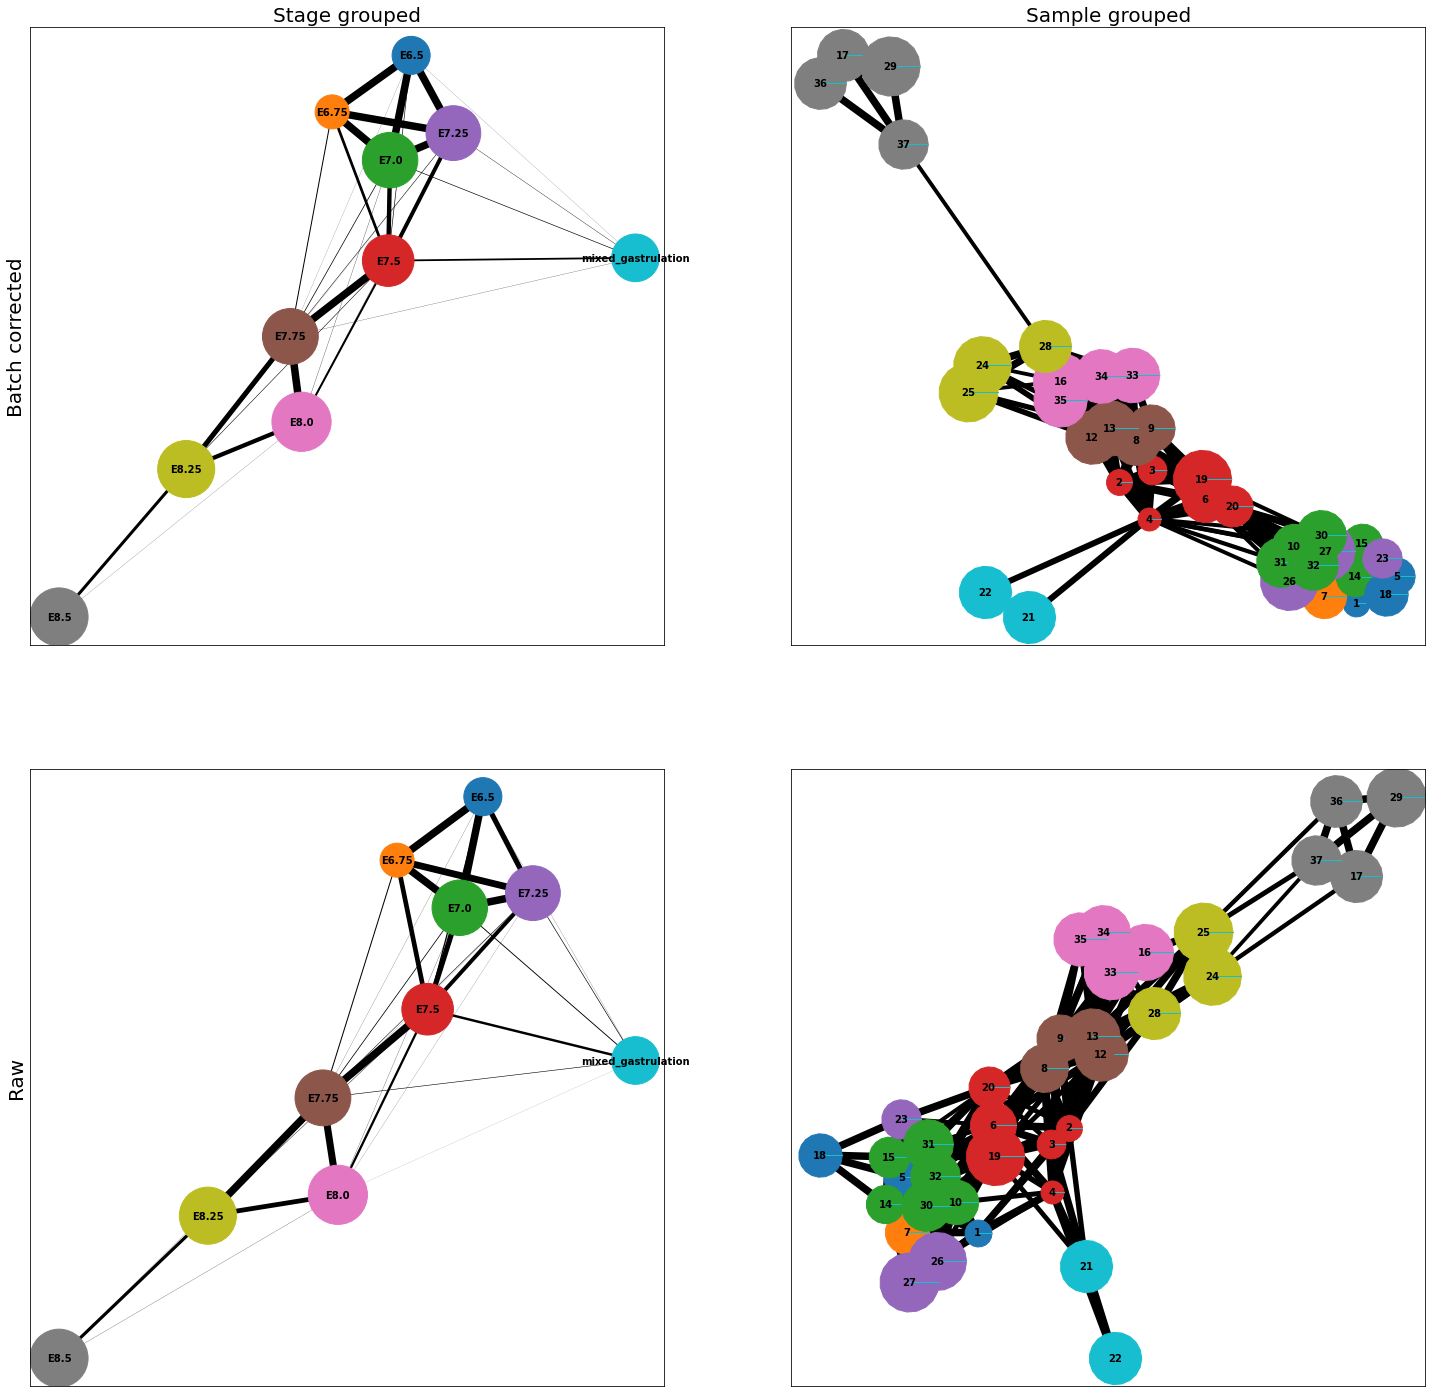

In [15]:
a.obs["sample"] = a.obs["sample"].astype(str)

fig,ax = plt.subplots(2,2,figsize=[25,25])

scp.pp.neighbors(a,knn=50,use_rep="X_pca_harmony")

scp.tl.paga(a,groups="stage")
scp.pl.paga(a,color="stage",node_size_scale=20,ax=ax[0,0],show=False)
ax[0,0].set_title("Stage grouped",fontsize=20)
ax[0,0].set_ylabel("Batch corrected",fontsize=20)

scp.tl.paga(a,groups="sample")
scp.pl.paga(a,color="stage",threshold=.5,node_size_scale=20,ax=ax[0,1],show=False)
ax[0,1].set_title("Sample grouped",fontsize=20)

scp.pp.neighbors(a,knn=50,use_rep="X_pca")

scp.tl.paga(a,groups="stage")
scp.pl.paga(a,color="stage",node_size_scale=20,ax=ax[1,0],show=False)
ax[1,0].set_ylabel("Raw",fontsize=20)

scp.tl.paga(a,groups="sample")
scp.pl.paga(a,color="stage",threshold=.5,node_size_scale=20,ax=ax[1,1],show=False)

fig.savefig("./Plots/6_Time_Integration/Paga_stages.png",bbox_inches="tight",transparent=True)

# Raw time integration

In [12]:
scp.pp.neighbors(a,n_neighbors=50,use_rep="X_pca_harmony")
umap_seed_with_paga(a,resolution=LOUVAIN_INITIALISATION)
scp.tl.umap(a,init_pos="paga")
scp.tl.draw_graph(a,init="paga")

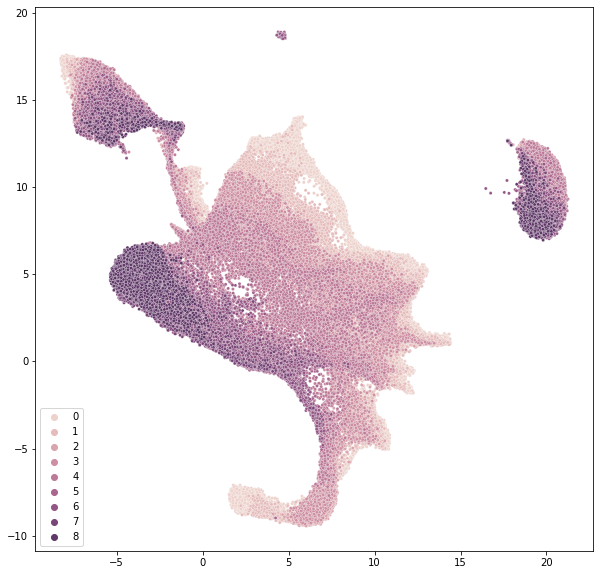

In [13]:
fig,ax=plt.subplots(1,1,figsize=[10,10])

l = ["E6.5","E6.75","E7.0","E7.25","E7.5","E7.75","E8.0","E8.25","E8.5"]
l.reverse()
for i,stage in enumerate(l):
    sb.scatterplot(a.obsm["X_umap"][a.obs["stage"]==stage,0],a.obsm["X_umap"][a.obs["stage"]==stage,1],hue=stage,hue_norm=(0,10),s=10,ax=ax)

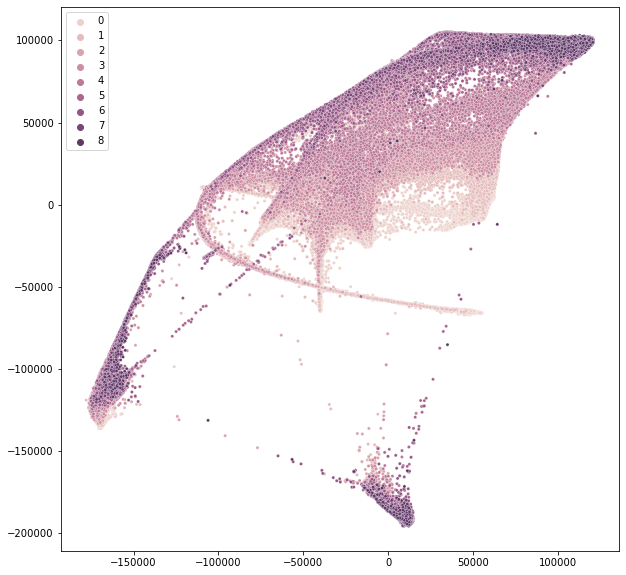

In [18]:
fig,ax=plt.subplots(1,1,figsize=[10,10])

l = ["E6.5","E6.75","E7.0","E7.25","E7.5","E7.75","E8.0","E8.25","E8.5"]
l.reverse()
for i,stage in enumerate(l):
    sb.scatterplot(a.obsm["X_draw_graph_fa"][a.obs["stage"]==stage,0],a.obsm["X_draw_graph_fa"][a.obs["stage"]==stage,1],hue=i,hue_norm=(0,10),s=10,ax=ax)


# Causal connection

In [10]:
b = a[a.obs["stage"]!="mixed_gastrulation",:]

In [11]:
bbknn.bbknn(b,use_rep="X_pca_harmony",batch_key="stage",n_pcs=N_PCS,metric=METRIC,neighbors_within_batch=N_NEIGBOURS)

Trying to set attribute `.uns` of view, copying.


In [12]:
def make_edges(a):

    #Disconnect
    m = pd.DataFrame()

    m["In"] = a.uns["neighbors"]["distances"].nonzero()[0]
    m["Out"] = a.uns["neighbors"]["distances"].nonzero()[1]
    m["Distances"] = np.array(a.uns["neighbors"]["distances"][m["In"],m["Out"]])[0]
    m["Connectivities"] = np.array(a.uns["neighbors"]["connectivities"][m["In"],m["Out"]])[0]
    m["StageIn"] = a.obs.loc[a.obs.iloc[m["In"]].index,"stage"].values
    m["StageOut"] = a.obs.loc[a.obs.iloc[m["Out"]].index,"stage"].values
    m["ClusterIn"] = a.obs.loc[a.obs.iloc[m["In"]].index,"Clusters_By_Stages"].values
    m["ClusterOut"] = a.obs.loc[a.obs.iloc[m["Out"]].index,"Clusters_By_Stages"].values
    m["Stage"] = [i+"_"+j for i,j in zip(m["StageIn"],m["StageOut"])]
    m["Cluster"] = [i+"_"+j for i,j in zip(m["ClusterIn"],m["ClusterOut"])]

    pos = np.array(range(119239))
    for i,stageIn in enumerate(["E6.5","E6.75","E7.0","E7.25","E7.5","E7.75","E8.0","E8.25","E8.5"]):
        for j,stageOut in enumerate(["E6.5","E6.75","E7.0","E7.25","E7.5","E7.75","E8.0","E8.25","E8.5"]):

            o0 = [i-1,i+1]
            
            if j not in o0:
                
                m = m.loc[m.loc[:,"Stage"] != (stageIn+"_"+stageOut),:]
    
    m["StageIn"] = m["StageIn"].cat.remove_unused_categories()
    m["StageOut"] = m["StageOut"].cat.remove_unused_categories()
    m["ClusterIn"] = m["ClusterIn"].cat.remove_unused_categories()
    m["ClusterOut"] = m["ClusterOut"].cat.remove_unused_categories()
    
    m["Forward"] = False
    for i,stageIn in enumerate(["E6.5","E6.75","E7.0","E7.25","E7.5","E7.75","E8.0","E8.25","E8.5"][:-1]):
        for j,stageOut in enumerate(["E6.5","E6.75","E7.0","E7.25","E7.5","E7.75","E8.0","E8.25","E8.5"][i+1:]):

                m.loc[m.loc[:,"Stage"] == (stageIn+"_"+stageOut),"Forward"] = True
#     m["Stage"] = m["Stage"].cat.remove_unused_categories()

    return m
    
# distances_prunned = sp.sparse.csc_matrix((m["Distances"],(m["In"],m["Out"])))
# connectivities_prunned = sp.sparse.csc_matrix((m["Connectivities"],(m["In"],m["Out"])))

In [13]:
m = make_edges(b)

In [37]:
s = m[m["Forward"].values].groupby(["ClusterIn","ClusterOut"]).size().unstack()
s2 = m[np.invert(m["Forward"].values)].groupby(["ClusterOut","ClusterIn"]).size().unstack()
ss = s + s2

sCompensatedIn = ss.transpose()
sCompensatedIn = sCompensatedIn/sCompensatedIn.sum(axis=0)
sCompensatedIn = sCompensatedIn.transpose()

sIn = s.transpose()
sIn = sIn/sIn.sum(axis=0)
sIn = sIn.transpose()

sIn = sIn.fillna(0)

sOut = s2.transpose()
sOut = sOut/sOut.sum(axis=0)
sOut = sOut.transpose()

sOut = sOut.fillna(0)

In [38]:
g = igraph.Graph.Adjacency(ss.values>0)
g.vs["cluster"] = ss.index.values
g.vs["annotation"] = [a.obs.loc[a.obs["Clusters_By_Stages"]==j["cluster"],"Manual_Annotation"][0] for j in g.vs]
g.es["weightForward"] = [sIn.iloc[i,j] for i,j in g.get_edgelist()]
g.es["weightBackward"] = [sOut.iloc[i,j] for i,j in g.get_edgelist()]
g.es["weightCompensatedForward"] = [sCompensatedIn.iloc[i,j] for i,j in g.get_edgelist()]

In [39]:
import json

data = []
for i,n in enumerate(g.vs):
    
    stage_num = float(n["cluster"].split("E")[1].split("_")[0])
    
    data_prop = {
        "id": "n_"+str(i),
        "cluster": n["cluster"],
        "annotation": n["annotation"],
        "stage": stage_num,
        "stageInt": int(stage_num*4-6.5*4)
      }
    
    for i in geneList[:5]:
        data_prop[i] = float(a[a.obs["Clusters_By_Stages"]==n["cluster"],a.var["Gene"]==i].X.mean())
    
    node = {
      "data": data_prop}
    
    data.append(node)
    
for i,n in enumerate(g.es):
    
    edge = {
      "data": {
        "id": "e_"+str(i),
        "source": "n_"+str(n.source),
        "target": "n_"+str(n.target),
        "weightForward": n["weightForward"],
        "weightBackward": n["weightBackward"],
        "weightCompensatedForward": n["weightCompensatedForward"]
      }}
    
    data.append(edge)

with open('./cytoscape/datasets/data.json', 'w') as outfile:
    json.dump(data, outfile)

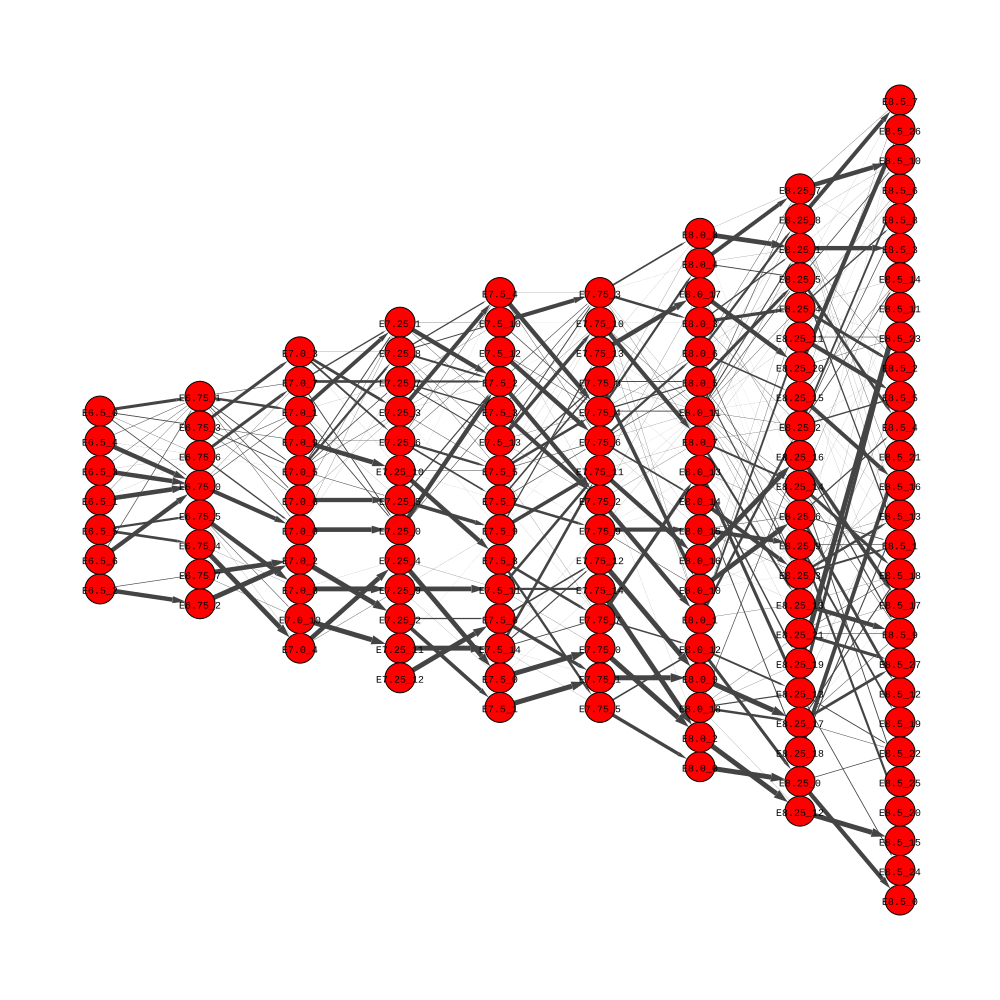

In [21]:
visual_style = {}
visual_style["edge_width"] = [5*float(i) for i in g.es["weight"]]
visual_style["vertex_size"] = 30
visual_style["vertex_label"] = g.vs["Name"]
visual_style["margin"] = 100

for i in range(len(g.vs)):
    g.vs[i]["label_size"] = 10
    
for i in g.es:
    i["arrow_size"] = i["weight"]
    i["arrow_width"] = i["weight"]

    
pos = g.layout_sugiyama(weights=np.array(g.es["weight"]),hgap=100,maxiter=200000)

x = [i[1] for i in pos]
y = [i[0] for i in pos]
n = [g.vs["Name"][i] for i in np.argsort(y)]

f=10
pos = []
for i in g.vs["Name"]:
    stage = i.split("_")[0]
    j = float(i.split("_")[1])
    ll = len(a.obs.loc[a.obs["stage"]==stage,"Clusters_By_Stages"].unique())
    p = float(i.split("E")[-1].split("_")[0])
    j = np.where(np.array([m for m in n if stage in m])==i)[0]
    pos.append([p,f*j-f*ll/2])

igraph.plot(g,layout=pos,bbox=(0,0,1000,1000),**visual_style)

## Check causality connections

In [207]:
a.uns["neighbors"]["distances"] = distances_prunned.copy()
a.uns["neighbors"]["connectivities"] = connectivities_prunned.copy()

In [208]:
scp.tl.paga(a,groups="stage")

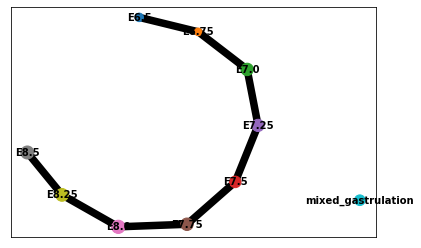

In [209]:
scp.pl.paga(a,layout="fr")

In [210]:
b = a[a.obs["stage"]!="mixed_gastrulation"]

In [211]:
scp.tl.paga(b,groups="Clusters_By_Stages")

Trying to set attribute `.uns` of view, copying.


In [275]:
b.obs["Clusters_By_Stages"].unique()

['E6.5_1', 'E6.5_0', 'E6.5_4', 'E6.5_3', 'E6.5_5', ..., 'E8.25_9', 'E8.25_17', 'E8.25_15', 'E8.25_21', 'E8.0_18']
Length: 138
Categories (138, object): ['E6.5_1', 'E6.5_0', 'E6.5_4', 'E6.5_3', ..., 'E8.25_17', 'E8.25_15', 'E8.25_21', 'E8.0_18']

<AxesSubplot:>

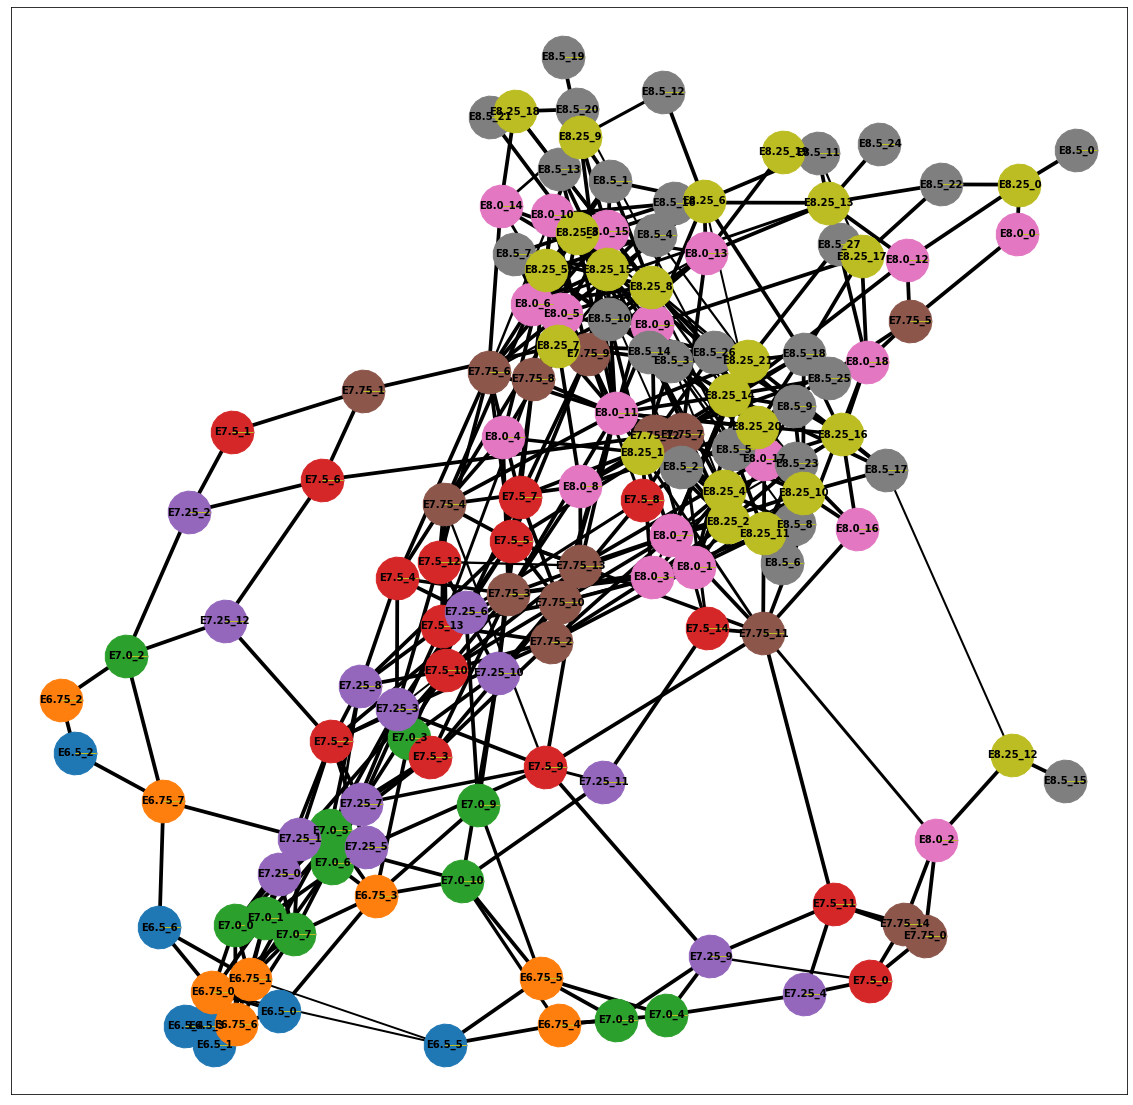

In [289]:
fig,ax=plt.subplots(1,1,figsize=[20,20])

f=5
pos = []
for i,stage in enumerate(["E6.5","E6.75","E7.0","E7.5","E7.25","E7.75","E8.0","E8.5","E8.25"]):
    l = len(b.obs.loc[b.obs["stage"]==stage,"Clusters_By_Stages"].unique())
    p = float(stage.split("E")[-1].split("_")[0])
    for j in range(l):
        pos.append([p,f*j-f*l/2])
        
# print(pos)
pos = np.array(pos)
scp.pl.paga(b,color="stage",layout="fa",edge_width_scale=0.5,ax=ax,show=False,threshold=.5,node_size_scale=20,node_size_power=0)

# A la Klein

In [4]:
from sklearn import preprocessing
from sklearn.decomposition import PCA, TruncatedSVD

In [5]:
l = (a.obs["stage"]=="E8.5") + (a.obs["stage"]=="E8.25") 
b = a[l,:].copy()

In [6]:
scp.pp.log1p(b)
scp.pp.highly_variable_genes(b,flavor=par.HVG_METHOD)

In [7]:
X = b[b.obs["stage"]=="E8.5",b.var["highly_variable"]].X.copy()
X2 = b[b.obs["stage"]=="E8.25",b.var["highly_variable"]].X.copy()

In [8]:
X_norm = preprocessing.MaxAbsScaler().fit_transform(X)
X2_norm = preprocessing.MaxAbsScaler().fit_transform(X2)

In [9]:
model = TruncatedSVD(n_components=par.N_PCS).fit(X_norm)

In [10]:
X_pca = model.fit_transform(X_norm)
X2_pca = model.fit_transform(X2_norm)

In [11]:
b.obsm["X_pca"] = np.zeros([b.shape[0],par.N_PCS])
b.obsm["X_pca"][b.obs["stage"]=="E8.5",:] = X_pca
b.obsm["X_pca"][b.obs["stage"]=="E8.25",:] = X2_pca

In [12]:
#Make nearest neighbours (1)
scp.pp.neighbors(b,metric=par.METRIC,knn=200,use_rep="X_pca",n_pcs=par.N_PCS)
d = b.obsp["distances"].copy()
d

<32588x32588 sparse matrix of type '<class 'numpy.float64'>'
	with 456232 stored elements in Compressed Sparse Row format>

In [13]:
#Cutoff local (2)
maxDistance = 3*(d.power(-1).max(axis=1).power(-1)).toarray()
loc_remove = sp.sparse.csc_matrix((d > maxDistance)).nonzero()
d[loc_remove] = 0
d.eliminate_zeros()
d

<32588x32588 sparse matrix of type '<class 'numpy.float64'>'
	with 455744 stored elements in Compressed Sparse Row format>

In [14]:
#Cutoff global (3)
s1 = b.obs["stage"]=="E8.5"
s2 = b.obs["stage"]=="E8.25"

#Remove between samples
mean_across_samples = (d[s1][:,s2].sum()+d[s2][:,s1].sum())/(d[s1][:,s2].data.shape[0]+d[s2][:,s1].data.shape[0])

loc = (np.array([i for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s1[i] and s2[j]])
       ,np.array([j for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s1[i] and s2[j]]))

v = d[loc]
v[d[loc] > mean_across_samples] = 0
d[loc] = v

loc = (np.array([i for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s2[i] and s1[j]])
       ,np.array([j for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s2[i] and s1[j]]))

v = d[loc]
v[d[loc] > mean_across_samples] = 0
d[loc] = v

#Remove within sample
meanDistance = d[s1][:,s1].sum()/d[s1][:,s1].data.shape[0]
stdDistance = np.sqrt(d[s1][:,s1].power(2).sum()/d[s1][:,s1].data.shape[0]-np.power(d[s1][:,s1].sum()/d[s1][:,s1].data.shape[0],2))
maxDistance_s1 = (meanDistance+stdDistance)

meanDistance = d[s2][:,s2].sum()/d[s2][:,s2].data.shape[0]
stdDistance = np.sqrt(d[s2][:,s2].power(2).sum()/d[s2][:,s2].data.shape[0]-np.power(d[s2][:,s2].sum()/d[s2][:,s2].data.shape[0],2))
maxDistance_s2 = (meanDistance+stdDistance)

loc = (np.array([i for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s1[i] and s1[j]])
       ,np.array([j for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s1[i] and s1[j]]))

for i,j in zip(loc[0],loc[1]):
    if d[i,j] > maxDistance_s1:
        d[i,j] = 0
        
loc = (np.array([i for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s2[i] and s2[j]])
       ,np.array([j for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s2[i] and s2[j]]))

for i,j in zip(loc[0],loc[1]):
    if d[i,j] > maxDistance_s2:
        d[i,j] = 0
        
d.eliminate_zeros()
d

<32588x32588 sparse matrix of type '<class 'numpy.float64'>'
	with 395284 stored elements in Compressed Sparse Row format>

In [18]:
#Limit to 20 MNN
s1,s2 = d.nonzero()
d[s1,s2] = d[s2,s1]
d.eliminate_zeros()
d

<32588x32588 sparse matrix of type '<class 'numpy.float64'>'
	with 212660 stored elements in Compressed Sparse Row format>

# A la Klein modified

In [4]:
from sklearn import preprocessing
from sklearn.decomposition import PCA, TruncatedSVD

In [5]:
l2 = ['E8.5', 'E8.25', 'E8.0', 'E7.75', 'E7.5', 'E7.25', 'E7.0', 'E6.75']
l1 = ['E8.25', 'E8.0', 'E7.75', 'E7.5', 'E7.25', 'E7.0', 'E6.75', 'E6.5']

In [9]:
data_edges = pd.DataFrame()

for st1,st2 in zip(l1,l2):

    #Extract datasets
    l = (a.obs["stage"]==st1) + (a.obs["stage"]==st2) 
    b = a[l,:].copy()
    
    #Make list of cells for each stage
    s1 = b.obs["stage"]==st2
    s2 = b.obs["stage"]==st1
    
    #Log normalize
    scp.pp.log1p(b)
    
    #Extract HVGs of time i+1
    b2 = b[b.obs["stage"]==st2,:].copy()
    scp.pp.highly_variable_genes(b2,flavor=par.HVG_METHOD)
    hvg = b2.var["highly_variable"].values
    del b2
    
    #Make PCs of time i+1 and project the space of i
    X = b[b.obs["stage"]==st1,hvg].X.copy()
    X2 = b[b.obs["stage"]==st2,hvg].X.copy()

    X_norm = preprocessing.MaxAbsScaler().fit_transform(X)
    X2_norm = preprocessing.MaxAbsScaler().fit_transform(X2)
    
    model = TruncatedSVD(n_components=par.N_PCS).fit(X2_norm) #Fit with the later time point
    
    X_pca = model.transform(X_norm)
    X2_pca = model.transform(X2_norm)
    
    b.obsm["X_pca"] = np.zeros([b.shape[0],par.N_PCS])
    b.obsm["X_pca"][b.obs["stage"]==st1,:] = X_pca
    b.obsm["X_pca"][b.obs["stage"]==st2,:] = X2_pca
    
    #Make neighbours between stages (1)
    scp.external.pp.bbknn(b,"stage",metric=par.METRIC,neighbors_within_batch=10,use_rep="X_pca",n_pcs=par.N_PCS)
    d = b.obsp["distances"].copy()
    
    #Cutoff local (2)
    maxDistance = 3*(d.power(-1).max(axis=1).power(-1)).toarray()
    loc_remove = sp.sparse.csc_matrix((d > maxDistance)).nonzero()
    d[loc_remove] = 0
    d.eliminate_zeros()
    
    #Cutoff global (3)
        #Remove between samples
    mean_across_samples = (d[s1][:,s2].sum()+d[s2][:,s1].sum())/(d[s1][:,s2].data.shape[0]+d[s2][:,s1].data.shape[0])

    loc = (np.array([i for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s1[i] and s2[j]])
           ,np.array([j for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s1[i] and s2[j]]))

    v = d[loc]
    v[d[loc] > mean_across_samples] = 0
    d[loc] = v

    loc = (np.array([i for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s2[i] and s1[j]])
           ,np.array([j for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s2[i] and s1[j]]))

    v = d[loc]
    v[d[loc] > mean_across_samples] = 0
    d[loc] = v

        #Remove within sample
    meanDistance = d[s1][:,s1].sum()/d[s1][:,s1].data.shape[0]
    stdDistance = np.sqrt(d[s1][:,s1].power(2).sum()/d[s1][:,s1].data.shape[0]-np.power(d[s1][:,s1].sum()/d[s1][:,s1].data.shape[0],2))
    maxDistance_s1 = (meanDistance+stdDistance)

    meanDistance = d[s2][:,s2].sum()/d[s2][:,s2].data.shape[0]
    stdDistance = np.sqrt(d[s2][:,s2].power(2).sum()/d[s2][:,s2].data.shape[0]-np.power(d[s2][:,s2].sum()/d[s2][:,s2].data.shape[0],2))
    maxDistance_s2 = (meanDistance+stdDistance)

    loc = (np.array([i for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s1[i] and s1[j]])
           ,np.array([j for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s1[i] and s1[j]]))

    for i,j in zip(loc[0],loc[1]):
        if d[i,j] > maxDistance_s1:
            d[i,j] = 0

    loc = (np.array([i for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s2[i] and s2[j]])
           ,np.array([j for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s2[i] and s2[j]]))

    for i,j in zip(loc[0],loc[1]):
        if d[i,j] > maxDistance_s2:
            d[i,j] = 0

    d.eliminate_zeros()
    
    #Remove excess of neighbours 
    #s1,s2 = d.nonzero()
    #d[s1,s2] = d[s2,s1]
    #d.eliminate_zeros()    
    
    data_edges_aux = pd.DataFrame()
    data_edges_aux["source"] = b.obs.index[d.nonzero()[0]]
    data_edges_aux["target"] = b.obs.index[d.nonzero()[1]]
    data_edges_aux["value"] = d.data
    
    data_edges = data_edges.append(data_edges_aux)

In [10]:
data_edges.to_csv("./ManipulatedData/"+par.METRIC+"/tables/Klein_network_edges.csv")